Our aim is to reproduce an example from the paper:

[Inferring single-trial neural population dynamics using sequential auto-encoders](https://www.nature.com/articles/s41592-018-0109-9)

We will generate trajectories from a latent Lorentz attractor and apply LFADS to recover the latent dynamic. Instead of using the original code (https://lfads.github.io/lfads-run-manager/) we will use tensorflow 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import scipy.io
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import funs

# Sample from latent Lorenz attractor:


In [2]:
Time = 500
neuron_num = 20
datax = scipy.io.loadmat("xtrain_hati_k09.mat")
y_data = datax["x_train"].T
traj = scipy.io.loadmat("trj_hati_k09.mat")
traj = traj["trj"].T
print(traj.shape)

(500, 2)


(500, 20)
[-0.29027328 -0.22246802 -0.2510693  -0.15758082 -0.04476619 -0.17713165
 -0.21938863 -0.20708875 -0.15391883 -0.12014636 -0.17681502 -0.17377758
 -0.2984122  -0.21730112 -0.37662324 -0.12200343 -0.18085784 -0.04476617
 -0.37103513 -0.04476622]


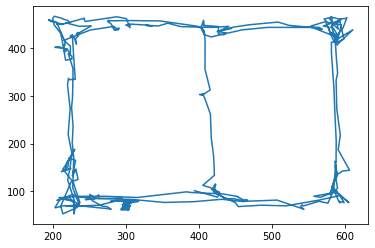

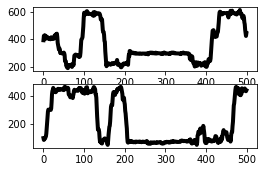

In [3]:
factor_dim = 2
Factor = np.random.randn(factor_dim,neuron_num)

NRep=1
output = np.zeros((NRep,Time,neuron_num))

for i in range(NRep):
    output[i,:,:] = y_data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    
output = output.astype('float32')

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
print(output.shape)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0,1])

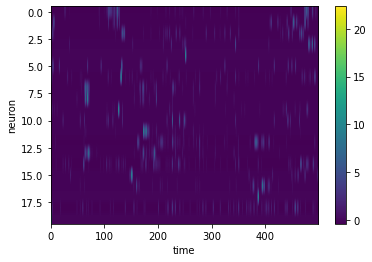

In [4]:
plt.figure()
plt.imshow(output[0,:,:].T,aspect='auto')
plt.xlabel('time')
plt.ylabel('neuron')
plt.colorbar()
plt.show()

In [5]:
# Create Tensorflow Dataset
dataset = tf.data.Dataset.from_tensor_slices((output))
dataset = dataset.shuffle(15, reshuffle_each_iteration=True)

# Autoencoder Model

In [6]:
tf.keras.backend.clear_session()

In [7]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class Encoder(tf.keras.layers.Layer):
    """Maps Trajectory to a triplet (z_mean, z_log_var, z)."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)        
        self.bidir_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_unit,return_sequences=False), 
                                                       input_shape=(sequence_length, num_input_neuron))
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.bidir_gru(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [9]:
class Decoder(tf.keras.layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    def __init__(self,
                 latent_dim=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='decoder',
                 **kwargs):
        self.sequence_length = sequence_length
        super(Decoder, self).__init__(name=name, **kwargs)
        self.recurrent_decoder = tf.keras.layers.GRU(latent_dim,return_sequences=True)#,use_bias=False)
        self.linear_bottleneck = tf.keras.layers.Dense(num_factor, activation=None)
        self.dense_output = tf.keras.layers.Dense(num_input_neuron, activation=None)
        self.latent_dim=latent_dim
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        null_input = tf.zeros([batch_size,self.sequence_length,self.latent_dim])
        decoder_output = self.recurrent_decoder(null_input, initial_state=inputs)
        x = self.linear_bottleneck(decoder_output)
        xo = self.dense_output(x)
        return xo, x

In [10]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim,num_gru_unit=num_gru_unit,sequence_length=sequence_length,
                               num_input_neuron=num_input_neuron)
        self.decoder = Decoder(latent_dim=latent_dim, sequence_length=sequence_length,
                              num_input_neuron=num_input_neuron,num_factor=num_factor)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)[0]
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
    def latent(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        latent = self.decoder(z)[1]
        return latent

In [11]:
BATCH_SIZE = 20
batched_dataset = dataset.batch(BATCH_SIZE)

In [12]:
vae = VariationalAutoEncoder(latent_dim=64,
                             num_gru_unit=128,
                             sequence_length=Time,
                             num_input_neuron=neuron_num,
                             num_factor=2)

# Train Model

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3,clipvalue=200)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

#### Linearly scheduling on the Kullback–Leibler divergence penalty:

We use a linearly increasing schedule on the Kullback–Leibler divergence penalty (as suggested [here](https://arxiv.org/pdf/1511.06349.pdf)) so that the optimization does not quickly (and pathologically) set the Kullback–Leibler divergence to 0


In [14]:
KL_penalty = np.linspace(0,1,4)

In [15]:
epochs = 3000

for i,kl_ in enumerate(KL_penalty):
    
    # Iterate over epochs.
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(batched_dataset):
            with tf.GradientTape() as tape:
                reconstructed = vae(x_batch_train)
                # Compute reconstruction loss
                loss = mse_loss_fn(x_batch_train, reconstructed)
                loss += kl_*sum(vae.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, vae.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae.trainable_weights))
            loss_metric(loss)

            if step % 100 == 0:
                print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()))

Start of epoch 0
step 0: mean loss = 0.9993757
Start of epoch 1
step 0: mean loss = 0.9992864
Start of epoch 2
step 0: mean loss = 0.9990352
Start of epoch 3
step 0: mean loss = 0.99890524
Start of epoch 4
step 0: mean loss = 0.9988127
Start of epoch 5
step 0: mean loss = 0.99877
Start of epoch 6
step 0: mean loss = 0.99877214
Start of epoch 7
step 0: mean loss = 0.9987396
Start of epoch 8
step 0: mean loss = 0.9986725
Start of epoch 9
step 0: mean loss = 0.9985506
Start of epoch 10
step 0: mean loss = 0.9984329
Start of epoch 11
step 0: mean loss = 0.99835914
Start of epoch 12
step 0: mean loss = 0.99831665
Start of epoch 13
step 0: mean loss = 0.998292
Start of epoch 14
step 0: mean loss = 0.99819976
Start of epoch 15
step 0: mean loss = 0.99810714
Start of epoch 16
step 0: mean loss = 0.99802554
Start of epoch 17
step 0: mean loss = 0.9979493
Start of epoch 18
step 0: mean loss = 0.99785715
Start of epoch 19
step 0: mean loss = 0.9977949
Start of epoch 20
step 0: mean loss = 0.99771

step 0: mean loss = 0.9830414
Start of epoch 170
step 0: mean loss = 0.9828883
Start of epoch 171
step 0: mean loss = 0.98273504
Start of epoch 172
step 0: mean loss = 0.9825811
Start of epoch 173
step 0: mean loss = 0.9824266
Start of epoch 174
step 0: mean loss = 0.98227173
Start of epoch 175
step 0: mean loss = 0.98211664
Start of epoch 176
step 0: mean loss = 0.9819612
Start of epoch 177
step 0: mean loss = 0.9818052
Start of epoch 178
step 0: mean loss = 0.981649
Start of epoch 179
step 0: mean loss = 0.98149246
Start of epoch 180
step 0: mean loss = 0.9813357
Start of epoch 181
step 0: mean loss = 0.98117894
Start of epoch 182
step 0: mean loss = 0.9810219
Start of epoch 183
step 0: mean loss = 0.98086464
Start of epoch 184
step 0: mean loss = 0.9807075
Start of epoch 185
step 0: mean loss = 0.9805502
Start of epoch 186
step 0: mean loss = 0.98039275
Start of epoch 187
step 0: mean loss = 0.98023534
Start of epoch 188
step 0: mean loss = 0.98007816
Start of epoch 189
step 0: mean

step 0: mean loss = 0.96361077
Start of epoch 336
step 0: mean loss = 0.96354175
Start of epoch 337
step 0: mean loss = 0.96347296
Start of epoch 338
step 0: mean loss = 0.96340466
Start of epoch 339
step 0: mean loss = 0.9633367
Start of epoch 340
step 0: mean loss = 0.9632691
Start of epoch 341
step 0: mean loss = 0.9632019
Start of epoch 342
step 0: mean loss = 0.963135
Start of epoch 343
step 0: mean loss = 0.9630686
Start of epoch 344
step 0: mean loss = 0.96300244
Start of epoch 345
step 0: mean loss = 0.96293664
Start of epoch 346
step 0: mean loss = 0.96287125
Start of epoch 347
step 0: mean loss = 0.96280617
Start of epoch 348
step 0: mean loss = 0.96274143
Start of epoch 349
step 0: mean loss = 0.96267706
Start of epoch 350
step 0: mean loss = 0.962613
Start of epoch 351
step 0: mean loss = 0.96254927
Start of epoch 352
step 0: mean loss = 0.96248597
Start of epoch 353
step 0: mean loss = 0.96242285
Start of epoch 354
step 0: mean loss = 0.96236014
Start of epoch 355
step 0: 

step 0: mean loss = 0.9557061
Start of epoch 502
step 0: mean loss = 0.95567346
Start of epoch 503
step 0: mean loss = 0.9556409
Start of epoch 504
step 0: mean loss = 0.9556085
Start of epoch 505
step 0: mean loss = 0.9555761
Start of epoch 506
step 0: mean loss = 0.9555439
Start of epoch 507
step 0: mean loss = 0.9555118
Start of epoch 508
step 0: mean loss = 0.9554798
Start of epoch 509
step 0: mean loss = 0.955448
Start of epoch 510
step 0: mean loss = 0.95541626
Start of epoch 511
step 0: mean loss = 0.9553847
Start of epoch 512
step 0: mean loss = 0.9553532
Start of epoch 513
step 0: mean loss = 0.95532185
Start of epoch 514
step 0: mean loss = 0.9552906
Start of epoch 515
step 0: mean loss = 0.95525944
Start of epoch 516
step 0: mean loss = 0.9552284
Start of epoch 517
step 0: mean loss = 0.9551975
Start of epoch 518
step 0: mean loss = 0.9551667
Start of epoch 519
step 0: mean loss = 0.955136
Start of epoch 520
step 0: mean loss = 0.9551054
Start of epoch 521
step 0: mean loss 

step 0: mean loss = 0.95154
Start of epoch 669
step 0: mean loss = 0.951521
Start of epoch 670
step 0: mean loss = 0.95150197
Start of epoch 671
step 0: mean loss = 0.9514831
Start of epoch 672
step 0: mean loss = 0.9514642
Start of epoch 673
step 0: mean loss = 0.95144534
Start of epoch 674
step 0: mean loss = 0.95142657
Start of epoch 675
step 0: mean loss = 0.9514079
Start of epoch 676
step 0: mean loss = 0.95138925
Start of epoch 677
step 0: mean loss = 0.95137066
Start of epoch 678
step 0: mean loss = 0.9513521
Start of epoch 679
step 0: mean loss = 0.95133364
Start of epoch 680
step 0: mean loss = 0.9513151
Start of epoch 681
step 0: mean loss = 0.9512966
Start of epoch 682
step 0: mean loss = 0.9512782
Start of epoch 683
step 0: mean loss = 0.95125985
Start of epoch 684
step 0: mean loss = 0.95124155
Start of epoch 685
step 0: mean loss = 0.9512233
Start of epoch 686
step 0: mean loss = 0.9512051
Start of epoch 687
step 0: mean loss = 0.95118695
Start of epoch 688
step 0: mean l

step 0: mean loss = 0.94894016
Start of epoch 836
step 0: mean loss = 0.94892734
Start of epoch 837
step 0: mean loss = 0.9489146
Start of epoch 838
step 0: mean loss = 0.94890183
Start of epoch 839
step 0: mean loss = 0.94888914
Start of epoch 840
step 0: mean loss = 0.9488765
Start of epoch 841
step 0: mean loss = 0.94886386
Start of epoch 842
step 0: mean loss = 0.9488512
Start of epoch 843
step 0: mean loss = 0.94883865
Start of epoch 844
step 0: mean loss = 0.9488261
Start of epoch 845
step 0: mean loss = 0.94881356
Start of epoch 846
step 0: mean loss = 0.94880104
Start of epoch 847
step 0: mean loss = 0.94878846
Start of epoch 848
step 0: mean loss = 0.94877595
Start of epoch 849
step 0: mean loss = 0.9487635
Start of epoch 850
step 0: mean loss = 0.94875103
Start of epoch 851
step 0: mean loss = 0.94873863
Start of epoch 852
step 0: mean loss = 0.94872624
Start of epoch 853
step 0: mean loss = 0.9487139
Start of epoch 854
step 0: mean loss = 0.94870156
Start of epoch 855
step 0

step 0: mean loss = 0.9471108
Start of epoch 1002
step 0: mean loss = 0.9471012
Start of epoch 1003
step 0: mean loss = 0.94709164
Start of epoch 1004
step 0: mean loss = 0.9470821
Start of epoch 1005
step 0: mean loss = 0.94707257
Start of epoch 1006
step 0: mean loss = 0.9470631
Start of epoch 1007
step 0: mean loss = 0.94705355
Start of epoch 1008
step 0: mean loss = 0.94704413
Start of epoch 1009
step 0: mean loss = 0.94703466
Start of epoch 1010
step 0: mean loss = 0.94702524
Start of epoch 1011
step 0: mean loss = 0.9470158
Start of epoch 1012
step 0: mean loss = 0.9470064
Start of epoch 1013
step 0: mean loss = 0.94699705
Start of epoch 1014
step 0: mean loss = 0.9469876
Start of epoch 1015
step 0: mean loss = 0.9469782
Start of epoch 1016
step 0: mean loss = 0.94696885
Start of epoch 1017
step 0: mean loss = 0.9469595
Start of epoch 1018
step 0: mean loss = 0.94695014
Start of epoch 1019
step 0: mean loss = 0.94694084
Start of epoch 1020
step 0: mean loss = 0.94693154
Start of 

step 0: mean loss = 0.9457116
Start of epoch 1165
step 0: mean loss = 0.94570386
Start of epoch 1166
step 0: mean loss = 0.94569606
Start of epoch 1167
step 0: mean loss = 0.9456883
Start of epoch 1168
step 0: mean loss = 0.9456806
Start of epoch 1169
step 0: mean loss = 0.94567287
Start of epoch 1170
step 0: mean loss = 0.9456652
Start of epoch 1171
step 0: mean loss = 0.9456575
Start of epoch 1172
step 0: mean loss = 0.9456498
Start of epoch 1173
step 0: mean loss = 0.9456421
Start of epoch 1174
step 0: mean loss = 0.9456344
Start of epoch 1175
step 0: mean loss = 0.9456268
Start of epoch 1176
step 0: mean loss = 0.94561917
Start of epoch 1177
step 0: mean loss = 0.9456115
Start of epoch 1178
step 0: mean loss = 0.9456037
Start of epoch 1179
step 0: mean loss = 0.94559604
Start of epoch 1180
step 0: mean loss = 0.94558835
Start of epoch 1181
step 0: mean loss = 0.9455807
Start of epoch 1182
step 0: mean loss = 0.94557303
Start of epoch 1183
step 0: mean loss = 0.9455654
Start of epoc

step 0: mean loss = 0.9445183
Start of epoch 1328
step 0: mean loss = 0.9445112
Start of epoch 1329
step 0: mean loss = 0.9445041
Start of epoch 1330
step 0: mean loss = 0.944497
Start of epoch 1331
step 0: mean loss = 0.9444899
Start of epoch 1332
step 0: mean loss = 0.9444828
Start of epoch 1333
step 0: mean loss = 0.94447577
Start of epoch 1334
step 0: mean loss = 0.9444687
Start of epoch 1335
step 0: mean loss = 0.9444616
Start of epoch 1336
step 0: mean loss = 0.94445443
Start of epoch 1337
step 0: mean loss = 0.94444734
Start of epoch 1338
step 0: mean loss = 0.94444025
Start of epoch 1339
step 0: mean loss = 0.94443315
Start of epoch 1340
step 0: mean loss = 0.94442606
Start of epoch 1341
step 0: mean loss = 0.94441897
Start of epoch 1342
step 0: mean loss = 0.94441193
Start of epoch 1343
step 0: mean loss = 0.9444049
Start of epoch 1344
step 0: mean loss = 0.9443978
Start of epoch 1345
step 0: mean loss = 0.94439083
Start of epoch 1346
step 0: mean loss = 0.9443838
Start of epo

step 0: mean loss = 0.9434319
Start of epoch 1491
step 0: mean loss = 0.94342583
Start of epoch 1492
step 0: mean loss = 0.9434197
Start of epoch 1493
step 0: mean loss = 0.9434136
Start of epoch 1494
step 0: mean loss = 0.94340754
Start of epoch 1495
step 0: mean loss = 0.94340146
Start of epoch 1496
step 0: mean loss = 0.94339544
Start of epoch 1497
step 0: mean loss = 0.94338936
Start of epoch 1498
step 0: mean loss = 0.9433834
Start of epoch 1499
step 0: mean loss = 0.9433774
Start of epoch 1500
step 0: mean loss = 0.94337136
Start of epoch 1501
step 0: mean loss = 0.94336534
Start of epoch 1502
step 0: mean loss = 0.9433593
Start of epoch 1503
step 0: mean loss = 0.9433533
Start of epoch 1504
step 0: mean loss = 0.9433473
Start of epoch 1505
step 0: mean loss = 0.9433413
Start of epoch 1506
step 0: mean loss = 0.9433353
Start of epoch 1507
step 0: mean loss = 0.94332933
Start of epoch 1508
step 0: mean loss = 0.9433234
Start of epoch 1509
step 0: mean loss = 0.9433174
Start of epo

step 0: mean loss = 0.9423434
Start of epoch 1654
step 0: mean loss = 0.9423269
Start of epoch 1655
step 0: mean loss = 0.94231176
Start of epoch 1656
step 0: mean loss = 0.9422944
Start of epoch 1657
step 0: mean loss = 0.94227636
Start of epoch 1658
step 0: mean loss = 0.9422598
Start of epoch 1659
step 0: mean loss = 0.94224286
Start of epoch 1660
step 0: mean loss = 0.9422237
Start of epoch 1661
step 0: mean loss = 0.94220406
Start of epoch 1662
step 0: mean loss = 0.94218564
Start of epoch 1663
step 0: mean loss = 0.9421682
Start of epoch 1664
step 0: mean loss = 0.9421496
Start of epoch 1665
step 0: mean loss = 0.9421288
Start of epoch 1666
step 0: mean loss = 0.942107
Start of epoch 1667
step 0: mean loss = 0.9420857
Start of epoch 1668
step 0: mean loss = 0.9420661
Start of epoch 1669
step 0: mean loss = 0.94204944
Start of epoch 1670
step 0: mean loss = 0.94203013
Start of epoch 1671
step 0: mean loss = 0.9420075
Start of epoch 1672
step 0: mean loss = 0.9419838
Start of epoch

step 0: mean loss = 0.9378527
Start of epoch 1817
step 0: mean loss = 0.9378232
Start of epoch 1818
step 0: mean loss = 0.9377935
Start of epoch 1819
step 0: mean loss = 0.9377641
Start of epoch 1820
step 0: mean loss = 0.9377354
Start of epoch 1821
step 0: mean loss = 0.937707
Start of epoch 1822
step 0: mean loss = 0.93767834
Start of epoch 1823
step 0: mean loss = 0.937649
Start of epoch 1824
step 0: mean loss = 0.93761945
Start of epoch 1825
step 0: mean loss = 0.93759
Start of epoch 1826
step 0: mean loss = 0.93756086
Start of epoch 1827
step 0: mean loss = 0.937532
Start of epoch 1828
step 0: mean loss = 0.9375031
Start of epoch 1829
step 0: mean loss = 0.93747383
Start of epoch 1830
step 0: mean loss = 0.9374444
Start of epoch 1831
step 0: mean loss = 0.9374149
Start of epoch 1832
step 0: mean loss = 0.9373855
Start of epoch 1833
step 0: mean loss = 0.93735635
Start of epoch 1834
step 0: mean loss = 0.9373274
Start of epoch 1835
step 0: mean loss = 0.9372984
Start of epoch 1836


step 0: mean loss = 0.9333448
Start of epoch 1980
step 0: mean loss = 0.93331844
Start of epoch 1981
step 0: mean loss = 0.93329215
Start of epoch 1982
step 0: mean loss = 0.9332662
Start of epoch 1983
step 0: mean loss = 0.9332406
Start of epoch 1984
step 0: mean loss = 0.93321526
Start of epoch 1985
step 0: mean loss = 0.93319017
Start of epoch 1986
step 0: mean loss = 0.93316436
Start of epoch 1987
step 0: mean loss = 0.9331382
Start of epoch 1988
step 0: mean loss = 0.93311197
Start of epoch 1989
step 0: mean loss = 0.93308604
Start of epoch 1990
step 0: mean loss = 0.93306035
Start of epoch 1991
step 0: mean loss = 0.9330349
Start of epoch 1992
step 0: mean loss = 0.93300956
Start of epoch 1993
step 0: mean loss = 0.93298376
Start of epoch 1994
step 0: mean loss = 0.9329577
Start of epoch 1995
step 0: mean loss = 0.9329316
Start of epoch 1996
step 0: mean loss = 0.93290555
Start of epoch 1997
step 0: mean loss = 0.93287975
Start of epoch 1998
step 0: mean loss = 0.93285406
Start o

step 0: mean loss = 0.92935044
Start of epoch 2143
step 0: mean loss = 0.9293279
Start of epoch 2144
step 0: mean loss = 0.9293055
Start of epoch 2145
step 0: mean loss = 0.9292826
Start of epoch 2146
step 0: mean loss = 0.9292596
Start of epoch 2147
step 0: mean loss = 0.9292364
Start of epoch 2148
step 0: mean loss = 0.9292131
Start of epoch 2149
step 0: mean loss = 0.92918974
Start of epoch 2150
step 0: mean loss = 0.92916644
Start of epoch 2151
step 0: mean loss = 0.9291431
Start of epoch 2152
step 0: mean loss = 0.9291197
Start of epoch 2153
step 0: mean loss = 0.92909646
Start of epoch 2154
step 0: mean loss = 0.9290733
Start of epoch 2155
step 0: mean loss = 0.92905027
Start of epoch 2156
step 0: mean loss = 0.9290275
Start of epoch 2157
step 0: mean loss = 0.9290051
Start of epoch 2158
step 0: mean loss = 0.9289832
Start of epoch 2159
step 0: mean loss = 0.92896104
Start of epoch 2160
step 0: mean loss = 0.9289387
Start of epoch 2161
step 0: mean loss = 0.928916
Start of epoch 

step 0: mean loss = 0.92577237
Start of epoch 2306
step 0: mean loss = 0.9257512
Start of epoch 2307
step 0: mean loss = 0.92573035
Start of epoch 2308
step 0: mean loss = 0.9257098
Start of epoch 2309
step 0: mean loss = 0.9256898
Start of epoch 2310
step 0: mean loss = 0.9256703
Start of epoch 2311
step 0: mean loss = 0.9256506
Start of epoch 2312
step 0: mean loss = 0.92563033
Start of epoch 2313
step 0: mean loss = 0.9256097
Start of epoch 2314
step 0: mean loss = 0.92558867
Start of epoch 2315
step 0: mean loss = 0.92556745
Start of epoch 2316
step 0: mean loss = 0.92554605
Start of epoch 2317
step 0: mean loss = 0.9255246
Start of epoch 2318
step 0: mean loss = 0.9255031
Start of epoch 2319
step 0: mean loss = 0.92548174
Start of epoch 2320
step 0: mean loss = 0.9254605
Start of epoch 2321
step 0: mean loss = 0.9254393
Start of epoch 2322
step 0: mean loss = 0.9254184
Start of epoch 2323
step 0: mean loss = 0.9253975
Start of epoch 2324
step 0: mean loss = 0.92537695
Start of epo

step 0: mean loss = 0.9225043
Start of epoch 2469
step 0: mean loss = 0.92248434
Start of epoch 2470
step 0: mean loss = 0.92246443
Start of epoch 2471
step 0: mean loss = 0.9224446
Start of epoch 2472
step 0: mean loss = 0.9224246
Start of epoch 2473
step 0: mean loss = 0.92240465
Start of epoch 2474
step 0: mean loss = 0.92238456
Start of epoch 2475
step 0: mean loss = 0.9223646
Start of epoch 2476
step 0: mean loss = 0.92234457
Start of epoch 2477
step 0: mean loss = 0.92232454
Start of epoch 2478
step 0: mean loss = 0.9223047
Start of epoch 2479
step 0: mean loss = 0.92228484
Start of epoch 2480
step 0: mean loss = 0.922265
Start of epoch 2481
step 0: mean loss = 0.922245
Start of epoch 2482
step 0: mean loss = 0.9222251
Start of epoch 2483
step 0: mean loss = 0.9222052
Start of epoch 2484
step 0: mean loss = 0.92218536
Start of epoch 2485
step 0: mean loss = 0.9221654
Start of epoch 2486
step 0: mean loss = 0.9221454
Start of epoch 2487
step 0: mean loss = 0.9221255
Start of epoch

step 0: mean loss = 0.9206569
Start of epoch 2632
step 0: mean loss = 0.92064166
Start of epoch 2633
step 0: mean loss = 0.92062646
Start of epoch 2634
step 0: mean loss = 0.9206113
Start of epoch 2635
step 0: mean loss = 0.9205961
Start of epoch 2636
step 0: mean loss = 0.92058086
Start of epoch 2637
step 0: mean loss = 0.92056566
Start of epoch 2638
step 0: mean loss = 0.9205504
Start of epoch 2639
step 0: mean loss = 0.9205352
Start of epoch 2640
step 0: mean loss = 0.9205199
Start of epoch 2641
step 0: mean loss = 0.92050457
Start of epoch 2642
step 0: mean loss = 0.9204893
Start of epoch 2643
step 0: mean loss = 0.92047405
Start of epoch 2644
step 0: mean loss = 0.92045873
Start of epoch 2645
step 0: mean loss = 0.92044336
Start of epoch 2646
step 0: mean loss = 0.92042804
Start of epoch 2647
step 0: mean loss = 0.92041266
Start of epoch 2648
step 0: mean loss = 0.9203973
Start of epoch 2649
step 0: mean loss = 0.92038184
Start of epoch 2650
step 0: mean loss = 0.9203665
Start of 

step 0: mean loss = 0.9181399
Start of epoch 2795
step 0: mean loss = 0.91812444
Start of epoch 2796
step 0: mean loss = 0.918109
Start of epoch 2797
step 0: mean loss = 0.9180936
Start of epoch 2798
step 0: mean loss = 0.91807824
Start of epoch 2799
step 0: mean loss = 0.91806275
Start of epoch 2800
step 0: mean loss = 0.9180473
Start of epoch 2801
step 0: mean loss = 0.9180318
Start of epoch 2802
step 0: mean loss = 0.9180164
Start of epoch 2803
step 0: mean loss = 0.91800094
Start of epoch 2804
step 0: mean loss = 0.91798556
Start of epoch 2805
step 0: mean loss = 0.91797006
Start of epoch 2806
step 0: mean loss = 0.91795456
Start of epoch 2807
step 0: mean loss = 0.9179391
Start of epoch 2808
step 0: mean loss = 0.9179236
Start of epoch 2809
step 0: mean loss = 0.9179082
Start of epoch 2810
step 0: mean loss = 0.9178927
Start of epoch 2811
step 0: mean loss = 0.91787714
Start of epoch 2812
step 0: mean loss = 0.91786164
Start of epoch 2813
step 0: mean loss = 0.91784614
Start of ep

step 0: mean loss = 0.91559404
Start of epoch 2958
step 0: mean loss = 0.9155786
Start of epoch 2959
step 0: mean loss = 0.91556317
Start of epoch 2960
step 0: mean loss = 0.9155477
Start of epoch 2961
step 0: mean loss = 0.9155323
Start of epoch 2962
step 0: mean loss = 0.915517
Start of epoch 2963
step 0: mean loss = 0.9155019
Start of epoch 2964
step 0: mean loss = 0.9154868
Start of epoch 2965
step 0: mean loss = 0.9154729
Start of epoch 2966
step 0: mean loss = 0.9154778
Start of epoch 2967
step 0: mean loss = 0.91548043
Start of epoch 2968
step 0: mean loss = 0.9154886
Start of epoch 2969
step 0: mean loss = 0.91549873
Start of epoch 2970
step 0: mean loss = 0.9155117
Start of epoch 2971
step 0: mean loss = 0.91551685
Start of epoch 2972
step 0: mean loss = 0.9155179
Start of epoch 2973
step 0: mean loss = 0.9155265
Start of epoch 2974
step 0: mean loss = 0.9155468
Start of epoch 2975
step 0: mean loss = 0.9155753
Start of epoch 2976
step 0: mean loss = 0.91559875
Start of epoch 

step 0: mean loss = 0.9423761
Start of epoch 126
step 0: mean loss = 0.94239646
Start of epoch 127
step 0: mean loss = 0.9424148
Start of epoch 128
step 0: mean loss = 0.9424348
Start of epoch 129
step 0: mean loss = 0.94245505
Start of epoch 130
step 0: mean loss = 0.9424728
Start of epoch 131
step 0: mean loss = 0.94249076
Start of epoch 132
step 0: mean loss = 0.94251114
Start of epoch 133
step 0: mean loss = 0.942528
Start of epoch 134
step 0: mean loss = 0.9425472
Start of epoch 135
step 0: mean loss = 0.94256663
Start of epoch 136
step 0: mean loss = 0.9425862
Start of epoch 137
step 0: mean loss = 0.9426052
Start of epoch 138
step 0: mean loss = 0.94262165
Start of epoch 139
step 0: mean loss = 0.9426393
Start of epoch 140
step 0: mean loss = 0.9426582
Start of epoch 141
step 0: mean loss = 0.9426778
Start of epoch 142
step 0: mean loss = 0.94269764
Start of epoch 143
step 0: mean loss = 0.9427149
Start of epoch 144
step 0: mean loss = 0.9427325
Start of epoch 145
step 0: mean l

step 0: mean loss = 0.9451444
Start of epoch 293
step 0: mean loss = 0.94516057
Start of epoch 294
step 0: mean loss = 0.9451739
Start of epoch 295
step 0: mean loss = 0.9451893
Start of epoch 296
step 0: mean loss = 0.94520366
Start of epoch 297
step 0: mean loss = 0.94521755
Start of epoch 298
step 0: mean loss = 0.94523245
Start of epoch 299
step 0: mean loss = 0.9452516
Start of epoch 300
step 0: mean loss = 0.9452681
Start of epoch 301
step 0: mean loss = 0.945284
Start of epoch 302
step 0: mean loss = 0.9452989
Start of epoch 303
step 0: mean loss = 0.94531274
Start of epoch 304
step 0: mean loss = 0.94532573
Start of epoch 305
step 0: mean loss = 0.9453403
Start of epoch 306
step 0: mean loss = 0.94535553
Start of epoch 307
step 0: mean loss = 0.94537044
Start of epoch 308
step 0: mean loss = 0.94538456
Start of epoch 309
step 0: mean loss = 0.94539976
Start of epoch 310
step 0: mean loss = 0.94541377
Start of epoch 311
step 0: mean loss = 0.9454305
Start of epoch 312
step 0: me

step 0: mean loss = 0.94743866
Start of epoch 460
step 0: mean loss = 0.9474524
Start of epoch 461
step 0: mean loss = 0.9474643
Start of epoch 462
step 0: mean loss = 0.9474772
Start of epoch 463
step 0: mean loss = 0.94748825
Start of epoch 464
step 0: mean loss = 0.9475017
Start of epoch 465
step 0: mean loss = 0.9475145
Start of epoch 466
step 0: mean loss = 0.94752693
Start of epoch 467
step 0: mean loss = 0.9475385
Start of epoch 468
step 0: mean loss = 0.9475506
Start of epoch 469
step 0: mean loss = 0.947562
Start of epoch 470
step 0: mean loss = 0.94757414
Start of epoch 471
step 0: mean loss = 0.9475849
Start of epoch 472
step 0: mean loss = 0.9475979
Start of epoch 473
step 0: mean loss = 0.9476104
Start of epoch 474
step 0: mean loss = 0.9476215
Start of epoch 475
step 0: mean loss = 0.9476313
Start of epoch 476
step 0: mean loss = 0.94764256
Start of epoch 477
step 0: mean loss = 0.94765437
Start of epoch 478
step 0: mean loss = 0.9476676
Start of epoch 479
step 0: mean lo

step 0: mean loss = 0.9492554
Start of epoch 627
step 0: mean loss = 0.9492645
Start of epoch 628
step 0: mean loss = 0.94927335
Start of epoch 629
step 0: mean loss = 0.94928575
Start of epoch 630
step 0: mean loss = 0.9493011
Start of epoch 631
step 0: mean loss = 0.9493115
Start of epoch 632
step 0: mean loss = 0.94931936
Start of epoch 633
step 0: mean loss = 0.9493306
Start of epoch 634
step 0: mean loss = 0.94933903
Start of epoch 635
step 0: mean loss = 0.949349
Start of epoch 636
step 0: mean loss = 0.94935805
Start of epoch 637
step 0: mean loss = 0.94936746
Start of epoch 638
step 0: mean loss = 0.9493743
Start of epoch 639
step 0: mean loss = 0.9493822
Start of epoch 640
step 0: mean loss = 0.9493882
Start of epoch 641
step 0: mean loss = 0.9493969
Start of epoch 642
step 0: mean loss = 0.9494036
Start of epoch 643
step 0: mean loss = 0.94941086
Start of epoch 644
step 0: mean loss = 0.9494221
Start of epoch 645
step 0: mean loss = 0.9494283
Start of epoch 646
step 0: mean l

step 0: mean loss = 0.9505591
Start of epoch 794
step 0: mean loss = 0.9505646
Start of epoch 795
step 0: mean loss = 0.95057696
Start of epoch 796
step 0: mean loss = 0.9505863
Start of epoch 797
step 0: mean loss = 0.9505934
Start of epoch 798
step 0: mean loss = 0.9506037
Start of epoch 799
step 0: mean loss = 0.9506107
Start of epoch 800
step 0: mean loss = 0.95061815
Start of epoch 801
step 0: mean loss = 0.9506221
Start of epoch 802
step 0: mean loss = 0.9506279
Start of epoch 803
step 0: mean loss = 0.95063347
Start of epoch 804
step 0: mean loss = 0.95064366
Start of epoch 805
step 0: mean loss = 0.95064765
Start of epoch 806
step 0: mean loss = 0.9506517
Start of epoch 807
step 0: mean loss = 0.95065707
Start of epoch 808
step 0: mean loss = 0.9506652
Start of epoch 809
step 0: mean loss = 0.95067555
Start of epoch 810
step 0: mean loss = 0.9506842
Start of epoch 811
step 0: mean loss = 0.95068985
Start of epoch 812
step 0: mean loss = 0.9506983
Start of epoch 813
step 0: mean

step 0: mean loss = 0.95142573
Start of epoch 960
step 0: mean loss = 0.9514273
Start of epoch 961
step 0: mean loss = 0.95143116
Start of epoch 962
step 0: mean loss = 0.95143324
Start of epoch 963
step 0: mean loss = 0.95143557
Start of epoch 964
step 0: mean loss = 0.9514409
Start of epoch 965
step 0: mean loss = 0.95144105
Start of epoch 966
step 0: mean loss = 0.9514457
Start of epoch 967
step 0: mean loss = 0.95144624
Start of epoch 968
step 0: mean loss = 0.95144916
Start of epoch 969
step 0: mean loss = 0.95145094
Start of epoch 970
step 0: mean loss = 0.9514534
Start of epoch 971
step 0: mean loss = 0.9514664
Start of epoch 972
step 0: mean loss = 0.95147336
Start of epoch 973
step 0: mean loss = 0.9514787
Start of epoch 974
step 0: mean loss = 0.95148504
Start of epoch 975
step 0: mean loss = 0.951488
Start of epoch 976
step 0: mean loss = 0.9514891
Start of epoch 977
step 0: mean loss = 0.95149827
Start of epoch 978
step 0: mean loss = 0.9515009
Start of epoch 979
step 0: me

step 0: mean loss = 0.95191365
Start of epoch 1124
step 0: mean loss = 0.9519135
Start of epoch 1125
step 0: mean loss = 0.9519143
Start of epoch 1126
step 0: mean loss = 0.9519163
Start of epoch 1127
step 0: mean loss = 0.95191896
Start of epoch 1128
step 0: mean loss = 0.9519223
Start of epoch 1129
step 0: mean loss = 0.95192933
Start of epoch 1130
step 0: mean loss = 0.95192873
Start of epoch 1131
step 0: mean loss = 0.9519286
Start of epoch 1132
step 0: mean loss = 0.95192814
Start of epoch 1133
step 0: mean loss = 0.95192975
Start of epoch 1134
step 0: mean loss = 0.951935
Start of epoch 1135
step 0: mean loss = 0.95193565
Start of epoch 1136
step 0: mean loss = 0.95193595
Start of epoch 1137
step 0: mean loss = 0.95193744
Start of epoch 1138
step 0: mean loss = 0.9519371
Start of epoch 1139
step 0: mean loss = 0.9519365
Start of epoch 1140
step 0: mean loss = 0.95193624
Start of epoch 1141
step 0: mean loss = 0.951937
Start of epoch 1142
step 0: mean loss = 0.9519364
Start of epo

step 0: mean loss = 0.95210356
Start of epoch 1287
step 0: mean loss = 0.9521061
Start of epoch 1288
step 0: mean loss = 0.952106
Start of epoch 1289
step 0: mean loss = 0.9521053
Start of epoch 1290
step 0: mean loss = 0.95210487
Start of epoch 1291
step 0: mean loss = 0.9521139
Start of epoch 1292
step 0: mean loss = 0.9521175
Start of epoch 1293
step 0: mean loss = 0.95211834
Start of epoch 1294
step 0: mean loss = 0.95211756
Start of epoch 1295
step 0: mean loss = 0.9521187
Start of epoch 1296
step 0: mean loss = 0.95211834
Start of epoch 1297
step 0: mean loss = 0.9521181
Start of epoch 1298
step 0: mean loss = 0.9521199
Start of epoch 1299
step 0: mean loss = 0.9521211
Start of epoch 1300
step 0: mean loss = 0.95212424
Start of epoch 1301
step 0: mean loss = 0.95212746
Start of epoch 1302
step 0: mean loss = 0.9521272
Start of epoch 1303
step 0: mean loss = 0.9521267
Start of epoch 1304
step 0: mean loss = 0.9521302
Start of epoch 1305
step 0: mean loss = 0.95212984
Start of epoc

step 0: mean loss = 0.9521654
Start of epoch 1450
step 0: mean loss = 0.95216465
Start of epoch 1451
step 0: mean loss = 0.952168
Start of epoch 1452
step 0: mean loss = 0.95217
Start of epoch 1453
step 0: mean loss = 0.9521756
Start of epoch 1454
step 0: mean loss = 0.95217615
Start of epoch 1455
step 0: mean loss = 0.9521752
Start of epoch 1456
step 0: mean loss = 0.9521734
Start of epoch 1457
step 0: mean loss = 0.9521827
Start of epoch 1458
step 0: mean loss = 0.952181
Start of epoch 1459
step 0: mean loss = 0.9521805
Start of epoch 1460
step 0: mean loss = 0.95218086
Start of epoch 1461
step 0: mean loss = 0.9521816
Start of epoch 1462
step 0: mean loss = 0.9521809
Start of epoch 1463
step 0: mean loss = 0.9521817
Start of epoch 1464
step 0: mean loss = 0.95218486
Start of epoch 1465
step 0: mean loss = 0.9521845
Start of epoch 1466
step 0: mean loss = 0.95218396
Start of epoch 1467
step 0: mean loss = 0.9521836
Start of epoch 1468
step 0: mean loss = 0.95218307
Start of epoch 146

step 0: mean loss = 0.95221007
Start of epoch 1613
step 0: mean loss = 0.95220876
Start of epoch 1614
step 0: mean loss = 0.952208
Start of epoch 1615
step 0: mean loss = 0.952207
Start of epoch 1616
step 0: mean loss = 0.9522068
Start of epoch 1617
step 0: mean loss = 0.952205
Start of epoch 1618
step 0: mean loss = 0.9522033
Start of epoch 1619
step 0: mean loss = 0.952202
Start of epoch 1620
step 0: mean loss = 0.95220065
Start of epoch 1621
step 0: mean loss = 0.9522
Start of epoch 1622
step 0: mean loss = 0.9521982
Start of epoch 1623
step 0: mean loss = 0.9522022
Start of epoch 1624
step 0: mean loss = 0.9522054
Start of epoch 1625
step 0: mean loss = 0.95220375
Start of epoch 1626
step 0: mean loss = 0.95220774
Start of epoch 1627
step 0: mean loss = 0.95221007
Start of epoch 1628
step 0: mean loss = 0.95220804
Start of epoch 1629
step 0: mean loss = 0.95220655
Start of epoch 1630
step 0: mean loss = 0.9522134
Start of epoch 1631
step 0: mean loss = 0.9522138
Start of epoch 1632

step 0: mean loss = 0.9521471
Start of epoch 1776
step 0: mean loss = 0.9521457
Start of epoch 1777
step 0: mean loss = 0.9521457
Start of epoch 1778
step 0: mean loss = 0.95214957
Start of epoch 1779
step 0: mean loss = 0.952159
Start of epoch 1780
step 0: mean loss = 0.9521575
Start of epoch 1781
step 0: mean loss = 0.952156
Start of epoch 1782
step 0: mean loss = 0.95215577
Start of epoch 1783
step 0: mean loss = 0.95215464
Start of epoch 1784
step 0: mean loss = 0.95215356
Start of epoch 1785
step 0: mean loss = 0.95215607
Start of epoch 1786
step 0: mean loss = 0.95215446
Start of epoch 1787
step 0: mean loss = 0.9521526
Start of epoch 1788
step 0: mean loss = 0.95215046
Start of epoch 1789
step 0: mean loss = 0.95215076
Start of epoch 1790
step 0: mean loss = 0.95214885
Start of epoch 1791
step 0: mean loss = 0.9521471
Start of epoch 1792
step 0: mean loss = 0.9521451
Start of epoch 1793
step 0: mean loss = 0.95214355
Start of epoch 1794
step 0: mean loss = 0.952143
Start of epoc

step 0: mean loss = 0.9520386
Start of epoch 1939
step 0: mean loss = 0.95203704
Start of epoch 1940
step 0: mean loss = 0.9520361
Start of epoch 1941
step 0: mean loss = 0.9520347
Start of epoch 1942
step 0: mean loss = 0.95203316
Start of epoch 1943
step 0: mean loss = 0.95203143
Start of epoch 1944
step 0: mean loss = 0.9520304
Start of epoch 1945
step 0: mean loss = 0.9520286
Start of epoch 1946
step 0: mean loss = 0.95202833
Start of epoch 1947
step 0: mean loss = 0.9520285
Start of epoch 1948
step 0: mean loss = 0.9520271
Start of epoch 1949
step 0: mean loss = 0.95202565
Start of epoch 1950
step 0: mean loss = 0.95202494
Start of epoch 1951
step 0: mean loss = 0.9520228
Start of epoch 1952
step 0: mean loss = 0.9520258
Start of epoch 1953
step 0: mean loss = 0.9520284
Start of epoch 1954
step 0: mean loss = 0.9520264
Start of epoch 1955
step 0: mean loss = 0.9520247
Start of epoch 1956
step 0: mean loss = 0.95202327
Start of epoch 1957
step 0: mean loss = 0.9520218
Start of epoc

step 0: mean loss = 0.9519016
Start of epoch 2102
step 0: mean loss = 0.9519001
Start of epoch 2103
step 0: mean loss = 0.9519005
Start of epoch 2104
step 0: mean loss = 0.9518987
Start of epoch 2105
step 0: mean loss = 0.9518973
Start of epoch 2106
step 0: mean loss = 0.95189553
Start of epoch 2107
step 0: mean loss = 0.9518967
Start of epoch 2108
step 0: mean loss = 0.9518949
Start of epoch 2109
step 0: mean loss = 0.95189464
Start of epoch 2110
step 0: mean loss = 0.9518933
Start of epoch 2111
step 0: mean loss = 0.9518948
Start of epoch 2112
step 0: mean loss = 0.95189315
Start of epoch 2113
step 0: mean loss = 0.95189494
Start of epoch 2114
step 0: mean loss = 0.95189315
Start of epoch 2115
step 0: mean loss = 0.95189196
Start of epoch 2116
step 0: mean loss = 0.9518901
Start of epoch 2117
step 0: mean loss = 0.9518897
Start of epoch 2118
step 0: mean loss = 0.95189154
Start of epoch 2119
step 0: mean loss = 0.9518919
Start of epoch 2120
step 0: mean loss = 0.95189035
Start of epo

step 0: mean loss = 0.9517392
Start of epoch 2265
step 0: mean loss = 0.9517373
Start of epoch 2266
step 0: mean loss = 0.9517373
Start of epoch 2267
step 0: mean loss = 0.95173526
Start of epoch 2268
step 0: mean loss = 0.95173365
Start of epoch 2269
step 0: mean loss = 0.95173234
Start of epoch 2270
step 0: mean loss = 0.9517304
Start of epoch 2271
step 0: mean loss = 0.9517284
Start of epoch 2272
step 0: mean loss = 0.95172626
Start of epoch 2273
step 0: mean loss = 0.9517259
Start of epoch 2274
step 0: mean loss = 0.95172393
Start of epoch 2275
step 0: mean loss = 0.9517218
Start of epoch 2276
step 0: mean loss = 0.95172
Start of epoch 2277
step 0: mean loss = 0.951718
Start of epoch 2278
step 0: mean loss = 0.9517158
Start of epoch 2279
step 0: mean loss = 0.95171463
Start of epoch 2280
step 0: mean loss = 0.95171386
Start of epoch 2281
step 0: mean loss = 0.95171255
Start of epoch 2282
step 0: mean loss = 0.9517107
Start of epoch 2283
step 0: mean loss = 0.95170885
Start of epoch

step 0: mean loss = 0.95157695
Start of epoch 2428
step 0: mean loss = 0.95157534
Start of epoch 2429
step 0: mean loss = 0.95157355
Start of epoch 2430
step 0: mean loss = 0.9515749
Start of epoch 2431
step 0: mean loss = 0.95157325
Start of epoch 2432
step 0: mean loss = 0.95157164
Start of epoch 2433
step 0: mean loss = 0.9515703
Start of epoch 2434
step 0: mean loss = 0.9515688
Start of epoch 2435
step 0: mean loss = 0.9515673
Start of epoch 2436
step 0: mean loss = 0.9515654
Start of epoch 2437
step 0: mean loss = 0.95156354
Start of epoch 2438
step 0: mean loss = 0.9515619
Start of epoch 2439
step 0: mean loss = 0.9515605
Start of epoch 2440
step 0: mean loss = 0.9515595
Start of epoch 2441
step 0: mean loss = 0.951559
Start of epoch 2442
step 0: mean loss = 0.95155823
Start of epoch 2443
step 0: mean loss = 0.95155644
Start of epoch 2444
step 0: mean loss = 0.9515571
Start of epoch 2445
step 0: mean loss = 0.95155954
Start of epoch 2446
step 0: mean loss = 0.9515596
Start of epo

step 0: mean loss = 0.95141155
Start of epoch 2591
step 0: mean loss = 0.9514125
Start of epoch 2592
step 0: mean loss = 0.95141155
Start of epoch 2593
step 0: mean loss = 0.95141
Start of epoch 2594
step 0: mean loss = 0.9514082
Start of epoch 2595
step 0: mean loss = 0.95140684
Start of epoch 2596
step 0: mean loss = 0.9514056
Start of epoch 2597
step 0: mean loss = 0.9514042
Start of epoch 2598
step 0: mean loss = 0.9514029
Start of epoch 2599
step 0: mean loss = 0.9514011
Start of epoch 2600
step 0: mean loss = 0.9513993
Start of epoch 2601
step 0: mean loss = 0.95139873
Start of epoch 2602
step 0: mean loss = 0.9513991
Start of epoch 2603
step 0: mean loss = 0.95139736
Start of epoch 2604
step 0: mean loss = 0.9513956
Start of epoch 2605
step 0: mean loss = 0.9513937
Start of epoch 2606
step 0: mean loss = 0.9513925
Start of epoch 2607
step 0: mean loss = 0.9513909
Start of epoch 2608
step 0: mean loss = 0.9513942
Start of epoch 2609
step 0: mean loss = 0.9513924
Start of epoch 26

step 0: mean loss = 0.9512364
Start of epoch 2754
step 0: mean loss = 0.9512352
Start of epoch 2755
step 0: mean loss = 0.95123374
Start of epoch 2756
step 0: mean loss = 0.951232
Start of epoch 2757
step 0: mean loss = 0.9512306
Start of epoch 2758
step 0: mean loss = 0.9512289
Start of epoch 2759
step 0: mean loss = 0.9512273
Start of epoch 2760
step 0: mean loss = 0.95122665
Start of epoch 2761
step 0: mean loss = 0.9512249
Start of epoch 2762
step 0: mean loss = 0.9512231
Start of epoch 2763
step 0: mean loss = 0.9512217
Start of epoch 2764
step 0: mean loss = 0.9512198
Start of epoch 2765
step 0: mean loss = 0.95122015
Start of epoch 2766
step 0: mean loss = 0.9512184
Start of epoch 2767
step 0: mean loss = 0.9512197
Start of epoch 2768
step 0: mean loss = 0.95121783
Start of epoch 2769
step 0: mean loss = 0.9512184
Start of epoch 2770
step 0: mean loss = 0.9512168
Start of epoch 2771
step 0: mean loss = 0.951215
Start of epoch 2772
step 0: mean loss = 0.9512177
Start of epoch 277

step 0: mean loss = 0.9510392
Start of epoch 2917
step 0: mean loss = 0.9510381
Start of epoch 2918
step 0: mean loss = 0.95103616
Start of epoch 2919
step 0: mean loss = 0.9510349
Start of epoch 2920
step 0: mean loss = 0.9510328
Start of epoch 2921
step 0: mean loss = 0.9510309
Start of epoch 2922
step 0: mean loss = 0.951029
Start of epoch 2923
step 0: mean loss = 0.951028
Start of epoch 2924
step 0: mean loss = 0.9510261
Start of epoch 2925
step 0: mean loss = 0.9510251
Start of epoch 2926
step 0: mean loss = 0.9510261
Start of epoch 2927
step 0: mean loss = 0.95102507
Start of epoch 2928
step 0: mean loss = 0.95102316
Start of epoch 2929
step 0: mean loss = 0.9510212
Start of epoch 2930
step 0: mean loss = 0.9510192
Start of epoch 2931
step 0: mean loss = 0.9510197
Start of epoch 2932
step 0: mean loss = 0.9510197
Start of epoch 2933
step 0: mean loss = 0.9510179
Start of epoch 2934
step 0: mean loss = 0.9510161
Start of epoch 2935
step 0: mean loss = 0.9510145
Start of epoch 2936

step 0: mean loss = 0.95086074
Start of epoch 84
step 0: mean loss = 0.95085907
Start of epoch 85
step 0: mean loss = 0.95085704
Start of epoch 86
step 0: mean loss = 0.9508553
Start of epoch 87
step 0: mean loss = 0.9508534
Start of epoch 88
step 0: mean loss = 0.9508529
Start of epoch 89
step 0: mean loss = 0.9508513
Start of epoch 90
step 0: mean loss = 0.95084953
Start of epoch 91
step 0: mean loss = 0.95084935
Start of epoch 92
step 0: mean loss = 0.9508474
Start of epoch 93
step 0: mean loss = 0.9508459
Start of epoch 94
step 0: mean loss = 0.9508441
Start of epoch 95
step 0: mean loss = 0.95084333
Start of epoch 96
step 0: mean loss = 0.9508414
Start of epoch 97
step 0: mean loss = 0.9508401
Start of epoch 98
step 0: mean loss = 0.950839
Start of epoch 99
step 0: mean loss = 0.9508421
Start of epoch 100
step 0: mean loss = 0.95084023
Start of epoch 101
step 0: mean loss = 0.9508382
Start of epoch 102
step 0: mean loss = 0.9508362
Start of epoch 103
step 0: mean loss = 0.95083576

step 0: mean loss = 0.95065975
Start of epoch 250
step 0: mean loss = 0.9506607
Start of epoch 251
step 0: mean loss = 0.9506593
Start of epoch 252
step 0: mean loss = 0.95066077
Start of epoch 253
step 0: mean loss = 0.9506592
Start of epoch 254
step 0: mean loss = 0.95065963
Start of epoch 255
step 0: mean loss = 0.95065796
Start of epoch 256
step 0: mean loss = 0.9506564
Start of epoch 257
step 0: mean loss = 0.95065475
Start of epoch 258
step 0: mean loss = 0.95065534
Start of epoch 259
step 0: mean loss = 0.95065385
Start of epoch 260
step 0: mean loss = 0.9506523
Start of epoch 261
step 0: mean loss = 0.9506514
Start of epoch 262
step 0: mean loss = 0.9506497
Start of epoch 263
step 0: mean loss = 0.95064795
Start of epoch 264
step 0: mean loss = 0.95064616
Start of epoch 265
step 0: mean loss = 0.95064515
Start of epoch 266
step 0: mean loss = 0.95064473
Start of epoch 267
step 0: mean loss = 0.95064354
Start of epoch 268
step 0: mean loss = 0.9506422
Start of epoch 269
step 0: 

step 0: mean loss = 0.9504618
Start of epoch 417
step 0: mean loss = 0.95045984
Start of epoch 418
step 0: mean loss = 0.9504602
Start of epoch 419
step 0: mean loss = 0.9504582
Start of epoch 420
step 0: mean loss = 0.95045644
Start of epoch 421
step 0: mean loss = 0.95045495
Start of epoch 422
step 0: mean loss = 0.950454
Start of epoch 423
step 0: mean loss = 0.9504524
Start of epoch 424
step 0: mean loss = 0.95045066
Start of epoch 425
step 0: mean loss = 0.95044947
Start of epoch 426
step 0: mean loss = 0.9504477
Start of epoch 427
step 0: mean loss = 0.95044583
Start of epoch 428
step 0: mean loss = 0.95044684
Start of epoch 429
step 0: mean loss = 0.950445
Start of epoch 430
step 0: mean loss = 0.9504434
Start of epoch 431
step 0: mean loss = 0.9504415
Start of epoch 432
step 0: mean loss = 0.95044094
Start of epoch 433
step 0: mean loss = 0.9504391
Start of epoch 434
step 0: mean loss = 0.9504372
Start of epoch 435
step 0: mean loss = 0.9504353
Start of epoch 436
step 0: mean l

step 0: mean loss = 0.95024705
Start of epoch 584
step 0: mean loss = 0.95024574
Start of epoch 585
step 0: mean loss = 0.95024437
Start of epoch 586
step 0: mean loss = 0.950243
Start of epoch 587
step 0: mean loss = 0.9502413
Start of epoch 588
step 0: mean loss = 0.95023984
Start of epoch 589
step 0: mean loss = 0.9502386
Start of epoch 590
step 0: mean loss = 0.95023704
Start of epoch 591
step 0: mean loss = 0.95023537
Start of epoch 592
step 0: mean loss = 0.95023406
Start of epoch 593
step 0: mean loss = 0.95023227
Start of epoch 594
step 0: mean loss = 0.9502309
Start of epoch 595
step 0: mean loss = 0.95022935
Start of epoch 596
step 0: mean loss = 0.9502289
Start of epoch 597
step 0: mean loss = 0.95022756
Start of epoch 598
step 0: mean loss = 0.9502278
Start of epoch 599
step 0: mean loss = 0.95022947
Start of epoch 600
step 0: mean loss = 0.95022774
Start of epoch 601
step 0: mean loss = 0.9502261
Start of epoch 602
step 0: mean loss = 0.95022625
Start of epoch 603
step 0: 

step 0: mean loss = 0.9500415
Start of epoch 750
step 0: mean loss = 0.9500397
Start of epoch 751
step 0: mean loss = 0.9500381
Start of epoch 752
step 0: mean loss = 0.95003647
Start of epoch 753
step 0: mean loss = 0.9500348
Start of epoch 754
step 0: mean loss = 0.95003325
Start of epoch 755
step 0: mean loss = 0.9500317
Start of epoch 756
step 0: mean loss = 0.95003015
Start of epoch 757
step 0: mean loss = 0.95002824
Start of epoch 758
step 0: mean loss = 0.9500264
Start of epoch 759
step 0: mean loss = 0.9500248
Start of epoch 760
step 0: mean loss = 0.9500231
Start of epoch 761
step 0: mean loss = 0.95002145
Start of epoch 762
step 0: mean loss = 0.9500205
Start of epoch 763
step 0: mean loss = 0.9500192
Start of epoch 764
step 0: mean loss = 0.95001805
Start of epoch 765
step 0: mean loss = 0.9500173
Start of epoch 766
step 0: mean loss = 0.9500155
Start of epoch 767
step 0: mean loss = 0.9500138
Start of epoch 768
step 0: mean loss = 0.9500144
Start of epoch 769
step 0: mean l

step 0: mean loss = 0.9498432
Start of epoch 916
step 0: mean loss = 0.94984174
Start of epoch 917
step 0: mean loss = 0.94984
Start of epoch 918
step 0: mean loss = 0.9498388
Start of epoch 919
step 0: mean loss = 0.94983715
Start of epoch 920
step 0: mean loss = 0.9498355
Start of epoch 921
step 0: mean loss = 0.949834
Start of epoch 922
step 0: mean loss = 0.94983274
Start of epoch 923
step 0: mean loss = 0.9498332
Start of epoch 924
step 0: mean loss = 0.9498315
Start of epoch 925
step 0: mean loss = 0.94983
Start of epoch 926
step 0: mean loss = 0.94982874
Start of epoch 927
step 0: mean loss = 0.94982785
Start of epoch 928
step 0: mean loss = 0.9498261
Start of epoch 929
step 0: mean loss = 0.9498245
Start of epoch 930
step 0: mean loss = 0.9498227
Start of epoch 931
step 0: mean loss = 0.94982094
Start of epoch 932
step 0: mean loss = 0.94981915
Start of epoch 933
step 0: mean loss = 0.9498181
Start of epoch 934
step 0: mean loss = 0.9498165
Start of epoch 935
step 0: mean loss 

step 0: mean loss = 0.949623
Start of epoch 1081
step 0: mean loss = 0.949622
Start of epoch 1082
step 0: mean loss = 0.94962066
Start of epoch 1083
step 0: mean loss = 0.9496192
Start of epoch 1084
step 0: mean loss = 0.94961756
Start of epoch 1085
step 0: mean loss = 0.949616
Start of epoch 1086
step 0: mean loss = 0.94961435
Start of epoch 1087
step 0: mean loss = 0.94961274
Start of epoch 1088
step 0: mean loss = 0.9496113
Start of epoch 1089
step 0: mean loss = 0.9496102
Start of epoch 1090
step 0: mean loss = 0.94960856
Start of epoch 1091
step 0: mean loss = 0.9496092
Start of epoch 1092
step 0: mean loss = 0.9496075
Start of epoch 1093
step 0: mean loss = 0.94960576
Start of epoch 1094
step 0: mean loss = 0.9496045
Start of epoch 1095
step 0: mean loss = 0.9496042
Start of epoch 1096
step 0: mean loss = 0.9496028
Start of epoch 1097
step 0: mean loss = 0.94960177
Start of epoch 1098
step 0: mean loss = 0.9496002
Start of epoch 1099
step 0: mean loss = 0.9495988
Start of epoch 1

step 0: mean loss = 0.9494064
Start of epoch 1244
step 0: mean loss = 0.9494052
Start of epoch 1245
step 0: mean loss = 0.9494035
Start of epoch 1246
step 0: mean loss = 0.9494023
Start of epoch 1247
step 0: mean loss = 0.94940066
Start of epoch 1248
step 0: mean loss = 0.9493991
Start of epoch 1249
step 0: mean loss = 0.9493987
Start of epoch 1250
step 0: mean loss = 0.94939834
Start of epoch 1251
step 0: mean loss = 0.94939727
Start of epoch 1252
step 0: mean loss = 0.9493958
Start of epoch 1253
step 0: mean loss = 0.9493962
Start of epoch 1254
step 0: mean loss = 0.9493968
Start of epoch 1255
step 0: mean loss = 0.9493952
Start of epoch 1256
step 0: mean loss = 0.94939363
Start of epoch 1257
step 0: mean loss = 0.94939286
Start of epoch 1258
step 0: mean loss = 0.94939166
Start of epoch 1259
step 0: mean loss = 0.94939005
Start of epoch 1260
step 0: mean loss = 0.94939077
Start of epoch 1261
step 0: mean loss = 0.9493926
Start of epoch 1262
step 0: mean loss = 0.949391
Start of epoc

step 0: mean loss = 0.9492036
Start of epoch 1407
step 0: mean loss = 0.9492022
Start of epoch 1408
step 0: mean loss = 0.9492006
Start of epoch 1409
step 0: mean loss = 0.94919896
Start of epoch 1410
step 0: mean loss = 0.9491974
Start of epoch 1411
step 0: mean loss = 0.94919586
Start of epoch 1412
step 0: mean loss = 0.94919443
Start of epoch 1413
step 0: mean loss = 0.9491929
Start of epoch 1414
step 0: mean loss = 0.9491913
Start of epoch 1415
step 0: mean loss = 0.9491898
Start of epoch 1416
step 0: mean loss = 0.94918853
Start of epoch 1417
step 0: mean loss = 0.9491871
Start of epoch 1418
step 0: mean loss = 0.9491882
Start of epoch 1419
step 0: mean loss = 0.9491865
Start of epoch 1420
step 0: mean loss = 0.94918495
Start of epoch 1421
step 0: mean loss = 0.94918334
Start of epoch 1422
step 0: mean loss = 0.9491839
Start of epoch 1423
step 0: mean loss = 0.9491824
Start of epoch 1424
step 0: mean loss = 0.9491807
Start of epoch 1425
step 0: mean loss = 0.9491793
Start of epoch

step 0: mean loss = 0.94899565
Start of epoch 1571
step 0: mean loss = 0.9489942
Start of epoch 1572
step 0: mean loss = 0.9489928
Start of epoch 1573
step 0: mean loss = 0.9489918
Start of epoch 1574
step 0: mean loss = 0.9489903
Start of epoch 1575
step 0: mean loss = 0.9489897
Start of epoch 1576
step 0: mean loss = 0.94898814
Start of epoch 1577
step 0: mean loss = 0.94898653
Start of epoch 1578
step 0: mean loss = 0.94898504
Start of epoch 1579
step 0: mean loss = 0.94898355
Start of epoch 1580
step 0: mean loss = 0.94898266
Start of epoch 1581
step 0: mean loss = 0.94898117
Start of epoch 1582
step 0: mean loss = 0.94898075
Start of epoch 1583
step 0: mean loss = 0.9489792
Start of epoch 1584
step 0: mean loss = 0.9489781
Start of epoch 1585
step 0: mean loss = 0.94897795
Start of epoch 1586
step 0: mean loss = 0.9489765
Start of epoch 1587
step 0: mean loss = 0.94897497
Start of epoch 1588
step 0: mean loss = 0.9489734
Start of epoch 1589
step 0: mean loss = 0.9489725
Start of e

step 0: mean loss = 0.9487966
Start of epoch 1734
step 0: mean loss = 0.9487952
Start of epoch 1735
step 0: mean loss = 0.94879365
Start of epoch 1736
step 0: mean loss = 0.9487925
Start of epoch 1737
step 0: mean loss = 0.9487911
Start of epoch 1738
step 0: mean loss = 0.9487902
Start of epoch 1739
step 0: mean loss = 0.9487891
Start of epoch 1740
step 0: mean loss = 0.9487876
Start of epoch 1741
step 0: mean loss = 0.94878614
Start of epoch 1742
step 0: mean loss = 0.9487847
Start of epoch 1743
step 0: mean loss = 0.9487832
Start of epoch 1744
step 0: mean loss = 0.9487819
Start of epoch 1745
step 0: mean loss = 0.94878054
Start of epoch 1746
step 0: mean loss = 0.9487792
Start of epoch 1747
step 0: mean loss = 0.94877774
Start of epoch 1748
step 0: mean loss = 0.9487772
Start of epoch 1749
step 0: mean loss = 0.9487757
Start of epoch 1750
step 0: mean loss = 0.94877434
Start of epoch 1751
step 0: mean loss = 0.9487729
Start of epoch 1752
step 0: mean loss = 0.94877154
Start of epoch

step 0: mean loss = 0.9485982
Start of epoch 1897
step 0: mean loss = 0.9485967
Start of epoch 1898
step 0: mean loss = 0.94859546
Start of epoch 1899
step 0: mean loss = 0.94859546
Start of epoch 1900
step 0: mean loss = 0.94859403
Start of epoch 1901
step 0: mean loss = 0.9485927
Start of epoch 1902
step 0: mean loss = 0.9485932
Start of epoch 1903
step 0: mean loss = 0.94859177
Start of epoch 1904
step 0: mean loss = 0.94859034
Start of epoch 1905
step 0: mean loss = 0.9485889
Start of epoch 1906
step 0: mean loss = 0.9485875
Start of epoch 1907
step 0: mean loss = 0.94858605
Start of epoch 1908
step 0: mean loss = 0.94858456
Start of epoch 1909
step 0: mean loss = 0.9485833
Start of epoch 1910
step 0: mean loss = 0.94858193
Start of epoch 1911
step 0: mean loss = 0.94858056
Start of epoch 1912
step 0: mean loss = 0.948579
Start of epoch 1913
step 0: mean loss = 0.94857794
Start of epoch 1914
step 0: mean loss = 0.94857675
Start of epoch 1915
step 0: mean loss = 0.9485753
Start of e

step 0: mean loss = 0.9484005
Start of epoch 2060
step 0: mean loss = 0.948399
Start of epoch 2061
step 0: mean loss = 0.9483975
Start of epoch 2062
step 0: mean loss = 0.9483961
Start of epoch 2063
step 0: mean loss = 0.9483948
Start of epoch 2064
step 0: mean loss = 0.9483934
Start of epoch 2065
step 0: mean loss = 0.948392
Start of epoch 2066
step 0: mean loss = 0.94839054
Start of epoch 2067
step 0: mean loss = 0.94838905
Start of epoch 2068
step 0: mean loss = 0.9483876
Start of epoch 2069
step 0: mean loss = 0.9483868
Start of epoch 2070
step 0: mean loss = 0.9483859
Start of epoch 2071
step 0: mean loss = 0.9483844
Start of epoch 2072
step 0: mean loss = 0.94838303
Start of epoch 2073
step 0: mean loss = 0.9483821
Start of epoch 2074
step 0: mean loss = 0.9483809
Start of epoch 2075
step 0: mean loss = 0.94837946
Start of epoch 2076
step 0: mean loss = 0.94837797
Start of epoch 2077
step 0: mean loss = 0.94837666
Start of epoch 2078
step 0: mean loss = 0.9483754
Start of epoch 2

step 0: mean loss = 0.948208
Start of epoch 2223
step 0: mean loss = 0.94820666
Start of epoch 2224
step 0: mean loss = 0.94820553
Start of epoch 2225
step 0: mean loss = 0.94820416
Start of epoch 2226
step 0: mean loss = 0.9482028
Start of epoch 2227
step 0: mean loss = 0.9482014
Start of epoch 2228
step 0: mean loss = 0.94820017
Start of epoch 2229
step 0: mean loss = 0.9481989
Start of epoch 2230
step 0: mean loss = 0.94819754
Start of epoch 2231
step 0: mean loss = 0.9481964
Start of epoch 2232
step 0: mean loss = 0.94819504
Start of epoch 2233
step 0: mean loss = 0.94819367
Start of epoch 2234
step 0: mean loss = 0.94819236
Start of epoch 2235
step 0: mean loss = 0.948191
Start of epoch 2236
step 0: mean loss = 0.9481898
Start of epoch 2237
step 0: mean loss = 0.94818836
Start of epoch 2238
step 0: mean loss = 0.9481869
Start of epoch 2239
step 0: mean loss = 0.9481859
Start of epoch 2240
step 0: mean loss = 0.94818485
Start of epoch 2241
step 0: mean loss = 0.94818383
Start of ep

step 0: mean loss = 0.94800377
Start of epoch 2386
step 0: mean loss = 0.94800246
Start of epoch 2387
step 0: mean loss = 0.94800115
Start of epoch 2388
step 0: mean loss = 0.9480018
Start of epoch 2389
step 0: mean loss = 0.94800043
Start of epoch 2390
step 0: mean loss = 0.94799924
Start of epoch 2391
step 0: mean loss = 0.94799787
Start of epoch 2392
step 0: mean loss = 0.9479965
Start of epoch 2393
step 0: mean loss = 0.94799507
Start of epoch 2394
step 0: mean loss = 0.9479937
Start of epoch 2395
step 0: mean loss = 0.9479924
Start of epoch 2396
step 0: mean loss = 0.94799113
Start of epoch 2397
step 0: mean loss = 0.94798976
Start of epoch 2398
step 0: mean loss = 0.94798857
Start of epoch 2399
step 0: mean loss = 0.94798726
Start of epoch 2400
step 0: mean loss = 0.9479859
Start of epoch 2401
step 0: mean loss = 0.94798464
Start of epoch 2402
step 0: mean loss = 0.94798326
Start of epoch 2403
step 0: mean loss = 0.9479824
Start of epoch 2404
step 0: mean loss = 0.947981
Start of

step 0: mean loss = 0.9478149
Start of epoch 2549
step 0: mean loss = 0.9478137
Start of epoch 2550
step 0: mean loss = 0.94781256
Start of epoch 2551
step 0: mean loss = 0.94781154
Start of epoch 2552
step 0: mean loss = 0.9478101
Start of epoch 2553
step 0: mean loss = 0.9478088
Start of epoch 2554
step 0: mean loss = 0.94780743
Start of epoch 2555
step 0: mean loss = 0.9478069
Start of epoch 2556
step 0: mean loss = 0.9478055
Start of epoch 2557
step 0: mean loss = 0.94780433
Start of epoch 2558
step 0: mean loss = 0.94780296
Start of epoch 2559
step 0: mean loss = 0.9478017
Start of epoch 2560
step 0: mean loss = 0.9478004
Start of epoch 2561
step 0: mean loss = 0.9477992
Start of epoch 2562
step 0: mean loss = 0.94779783
Start of epoch 2563
step 0: mean loss = 0.9477965
Start of epoch 2564
step 0: mean loss = 0.94779515
Start of epoch 2565
step 0: mean loss = 0.9477939
Start of epoch 2566
step 0: mean loss = 0.9477927
Start of epoch 2567
step 0: mean loss = 0.9477917
Start of epoc

step 0: mean loss = 0.9476275
Start of epoch 2712
step 0: mean loss = 0.9476262
Start of epoch 2713
step 0: mean loss = 0.9476253
Start of epoch 2714
step 0: mean loss = 0.94762397
Start of epoch 2715
step 0: mean loss = 0.94762284
Start of epoch 2716
step 0: mean loss = 0.9476219
Start of epoch 2717
step 0: mean loss = 0.94762063
Start of epoch 2718
step 0: mean loss = 0.9476193
Start of epoch 2719
step 0: mean loss = 0.9476182
Start of epoch 2720
step 0: mean loss = 0.9476169
Start of epoch 2721
step 0: mean loss = 0.9476156
Start of epoch 2722
step 0: mean loss = 0.94761425
Start of epoch 2723
step 0: mean loss = 0.9476129
Start of epoch 2724
step 0: mean loss = 0.94761145
Start of epoch 2725
step 0: mean loss = 0.9476103
Start of epoch 2726
step 0: mean loss = 0.94760907
Start of epoch 2727
step 0: mean loss = 0.94760776
Start of epoch 2728
step 0: mean loss = 0.9476065
Start of epoch 2729
step 0: mean loss = 0.94760525
Start of epoch 2730
step 0: mean loss = 0.94760406
Start of ep

step 0: mean loss = 0.94743735
Start of epoch 2876
step 0: mean loss = 0.94743603
Start of epoch 2877
step 0: mean loss = 0.9474348
Start of epoch 2878
step 0: mean loss = 0.9474336
Start of epoch 2879
step 0: mean loss = 0.94743234
Start of epoch 2880
step 0: mean loss = 0.9474311
Start of epoch 2881
step 0: mean loss = 0.94743013
Start of epoch 2882
step 0: mean loss = 0.9474289
Start of epoch 2883
step 0: mean loss = 0.9474281
Start of epoch 2884
step 0: mean loss = 0.94742674
Start of epoch 2885
step 0: mean loss = 0.9474254
Start of epoch 2886
step 0: mean loss = 0.94742405
Start of epoch 2887
step 0: mean loss = 0.94742286
Start of epoch 2888
step 0: mean loss = 0.9474215
Start of epoch 2889
step 0: mean loss = 0.9474204
Start of epoch 2890
step 0: mean loss = 0.9474193
Start of epoch 2891
step 0: mean loss = 0.947418
Start of epoch 2892
step 0: mean loss = 0.94741684
Start of epoch 2893
step 0: mean loss = 0.94741553
Start of epoch 2894
step 0: mean loss = 0.9474143
Start of epo

step 0: mean loss = 0.94724315
Start of epoch 41
step 0: mean loss = 0.9472418
Start of epoch 42
step 0: mean loss = 0.9472405
Start of epoch 43
step 0: mean loss = 0.9472393
Start of epoch 44
step 0: mean loss = 0.94723797
Start of epoch 45
step 0: mean loss = 0.9472369
Start of epoch 46
step 0: mean loss = 0.94723564
Start of epoch 47
step 0: mean loss = 0.9472345
Start of epoch 48
step 0: mean loss = 0.947235
Start of epoch 49
step 0: mean loss = 0.9472339
Start of epoch 50
step 0: mean loss = 0.94723296
Start of epoch 51
step 0: mean loss = 0.94723165
Start of epoch 52
step 0: mean loss = 0.9472306
Start of epoch 53
step 0: mean loss = 0.9472295
Start of epoch 54
step 0: mean loss = 0.94723034
Start of epoch 55
step 0: mean loss = 0.9472291
Start of epoch 56
step 0: mean loss = 0.947228
Start of epoch 57
step 0: mean loss = 0.9472279
Start of epoch 58
step 0: mean loss = 0.9472268
Start of epoch 59
step 0: mean loss = 0.9472255
Start of epoch 60
step 0: mean loss = 0.9472243
Start 

step 0: mean loss = 0.9470494
Start of epoch 209
step 0: mean loss = 0.94704837
Start of epoch 210
step 0: mean loss = 0.947047
Start of epoch 211
step 0: mean loss = 0.94704574
Start of epoch 212
step 0: mean loss = 0.9470446
Start of epoch 213
step 0: mean loss = 0.9470435
Start of epoch 214
step 0: mean loss = 0.9470421
Start of epoch 215
step 0: mean loss = 0.94704086
Start of epoch 216
step 0: mean loss = 0.94703996
Start of epoch 217
step 0: mean loss = 0.9470387
Start of epoch 218
step 0: mean loss = 0.94703746
Start of epoch 219
step 0: mean loss = 0.9470362
Start of epoch 220
step 0: mean loss = 0.94703496
Start of epoch 221
step 0: mean loss = 0.9470336
Start of epoch 222
step 0: mean loss = 0.9470324
Start of epoch 223
step 0: mean loss = 0.94703114
Start of epoch 224
step 0: mean loss = 0.94703007
Start of epoch 225
step 0: mean loss = 0.94702876
Start of epoch 226
step 0: mean loss = 0.9470275
Start of epoch 227
step 0: mean loss = 0.94702625
Start of epoch 228
step 0: mea

step 0: mean loss = 0.9468597
Start of epoch 376
step 0: mean loss = 0.94685864
Start of epoch 377
step 0: mean loss = 0.94685817
Start of epoch 378
step 0: mean loss = 0.9468569
Start of epoch 379
step 0: mean loss = 0.9468557
Start of epoch 380
step 0: mean loss = 0.94685453
Start of epoch 381
step 0: mean loss = 0.94685334
Start of epoch 382
step 0: mean loss = 0.94685274
Start of epoch 383
step 0: mean loss = 0.94685143
Start of epoch 384
step 0: mean loss = 0.94685024
Start of epoch 385
step 0: mean loss = 0.94684905
Start of epoch 386
step 0: mean loss = 0.94684786
Start of epoch 387
step 0: mean loss = 0.946847
Start of epoch 388
step 0: mean loss = 0.9468457
Start of epoch 389
step 0: mean loss = 0.9468445
Start of epoch 390
step 0: mean loss = 0.9468432
Start of epoch 391
step 0: mean loss = 0.946842
Start of epoch 392
step 0: mean loss = 0.9468407
Start of epoch 393
step 0: mean loss = 0.94684076
Start of epoch 394
step 0: mean loss = 0.94683987
Start of epoch 395
step 0: mea

step 0: mean loss = 0.94668436
Start of epoch 543
step 0: mean loss = 0.9466831
Start of epoch 544
step 0: mean loss = 0.94668204
Start of epoch 545
step 0: mean loss = 0.9466808
Start of epoch 546
step 0: mean loss = 0.9466796
Start of epoch 547
step 0: mean loss = 0.94667864
Start of epoch 548
step 0: mean loss = 0.9466774
Start of epoch 549
step 0: mean loss = 0.94667614
Start of epoch 550
step 0: mean loss = 0.9466748
Start of epoch 551
step 0: mean loss = 0.9466737
Start of epoch 552
step 0: mean loss = 0.9466724
Start of epoch 553
step 0: mean loss = 0.94667125
Start of epoch 554
step 0: mean loss = 0.94667
Start of epoch 555
step 0: mean loss = 0.9466687
Start of epoch 556
step 0: mean loss = 0.94666743
Start of epoch 557
step 0: mean loss = 0.9466663
Start of epoch 558
step 0: mean loss = 0.9466654
Start of epoch 559
step 0: mean loss = 0.94666415
Start of epoch 560
step 0: mean loss = 0.9466631
Start of epoch 561
step 0: mean loss = 0.946664
Start of epoch 562
step 0: mean los

step 0: mean loss = 0.9465015
Start of epoch 710
step 0: mean loss = 0.94650024
Start of epoch 711
step 0: mean loss = 0.9464991
Start of epoch 712
step 0: mean loss = 0.9464979
Start of epoch 713
step 0: mean loss = 0.9464968
Start of epoch 714
step 0: mean loss = 0.94649553
Start of epoch 715
step 0: mean loss = 0.9464944
Start of epoch 716
step 0: mean loss = 0.9464932
Start of epoch 717
step 0: mean loss = 0.94649196
Start of epoch 718
step 0: mean loss = 0.9464907
Start of epoch 719
step 0: mean loss = 0.9464895
Start of epoch 720
step 0: mean loss = 0.9464884
Start of epoch 721
step 0: mean loss = 0.94648755
Start of epoch 722
step 0: mean loss = 0.94648665
Start of epoch 723
step 0: mean loss = 0.9464857
Start of epoch 724
step 0: mean loss = 0.94648457
Start of epoch 725
step 0: mean loss = 0.94648343
Start of epoch 726
step 0: mean loss = 0.9464824
Start of epoch 727
step 0: mean loss = 0.9464812
Start of epoch 728
step 0: mean loss = 0.9464803
Start of epoch 729
step 0: mean 

step 0: mean loss = 0.94631684
Start of epoch 877
step 0: mean loss = 0.94631565
Start of epoch 878
step 0: mean loss = 0.9463146
Start of epoch 879
step 0: mean loss = 0.9463134
Start of epoch 880
step 0: mean loss = 0.94631463
Start of epoch 881
step 0: mean loss = 0.94631356
Start of epoch 882
step 0: mean loss = 0.9463125
Start of epoch 883
step 0: mean loss = 0.9463114
Start of epoch 884
step 0: mean loss = 0.9463102
Start of epoch 885
step 0: mean loss = 0.94630903
Start of epoch 886
step 0: mean loss = 0.94630796
Start of epoch 887
step 0: mean loss = 0.9463068
Start of epoch 888
step 0: mean loss = 0.94630575
Start of epoch 889
step 0: mean loss = 0.94630456
Start of epoch 890
step 0: mean loss = 0.94630337
Start of epoch 891
step 0: mean loss = 0.9463025
Start of epoch 892
step 0: mean loss = 0.9463014
Start of epoch 893
step 0: mean loss = 0.9463003
Start of epoch 894
step 0: mean loss = 0.94629925
Start of epoch 895
step 0: mean loss = 0.94629824
Start of epoch 896
step 0: m

step 0: mean loss = 0.9461508
Start of epoch 1043
step 0: mean loss = 0.94614965
Start of epoch 1044
step 0: mean loss = 0.94614846
Start of epoch 1045
step 0: mean loss = 0.9461473
Start of epoch 1046
step 0: mean loss = 0.94614625
Start of epoch 1047
step 0: mean loss = 0.9461451
Start of epoch 1048
step 0: mean loss = 0.94614404
Start of epoch 1049
step 0: mean loss = 0.9461429
Start of epoch 1050
step 0: mean loss = 0.94614196
Start of epoch 1051
step 0: mean loss = 0.9461409
Start of epoch 1052
step 0: mean loss = 0.94613975
Start of epoch 1053
step 0: mean loss = 0.9461386
Start of epoch 1054
step 0: mean loss = 0.9461377
Start of epoch 1055
step 0: mean loss = 0.9461367
Start of epoch 1056
step 0: mean loss = 0.94613564
Start of epoch 1057
step 0: mean loss = 0.9461347
Start of epoch 1058
step 0: mean loss = 0.9461336
Start of epoch 1059
step 0: mean loss = 0.9461325
Start of epoch 1060
step 0: mean loss = 0.94613135
Start of epoch 1061
step 0: mean loss = 0.94613045
Start of ep

step 0: mean loss = 0.9459881
Start of epoch 1206
step 0: mean loss = 0.945987
Start of epoch 1207
step 0: mean loss = 0.9459859
Start of epoch 1208
step 0: mean loss = 0.9459848
Start of epoch 1209
step 0: mean loss = 0.94598365
Start of epoch 1210
step 0: mean loss = 0.9459825
Start of epoch 1211
step 0: mean loss = 0.94598144
Start of epoch 1212
step 0: mean loss = 0.9459805
Start of epoch 1213
step 0: mean loss = 0.9459795
Start of epoch 1214
step 0: mean loss = 0.94597834
Start of epoch 1215
step 0: mean loss = 0.9459773
Start of epoch 1216
step 0: mean loss = 0.9459762
Start of epoch 1217
step 0: mean loss = 0.9459751
Start of epoch 1218
step 0: mean loss = 0.9459741
Start of epoch 1219
step 0: mean loss = 0.94597363
Start of epoch 1220
step 0: mean loss = 0.9459725
Start of epoch 1221
step 0: mean loss = 0.9459719
Start of epoch 1222
step 0: mean loss = 0.94597137
Start of epoch 1223
step 0: mean loss = 0.94597024
Start of epoch 1224
step 0: mean loss = 0.9459692
Start of epoch 

step 0: mean loss = 0.9458239
Start of epoch 1369
step 0: mean loss = 0.94582283
Start of epoch 1370
step 0: mean loss = 0.94582194
Start of epoch 1371
step 0: mean loss = 0.9458209
Start of epoch 1372
step 0: mean loss = 0.94581985
Start of epoch 1373
step 0: mean loss = 0.9458188
Start of epoch 1374
step 0: mean loss = 0.94581765
Start of epoch 1375
step 0: mean loss = 0.9458166
Start of epoch 1376
step 0: mean loss = 0.9458155
Start of epoch 1377
step 0: mean loss = 0.9458147
Start of epoch 1378
step 0: mean loss = 0.9458139
Start of epoch 1379
step 0: mean loss = 0.94581294
Start of epoch 1380
step 0: mean loss = 0.9458118
Start of epoch 1381
step 0: mean loss = 0.94581074
Start of epoch 1382
step 0: mean loss = 0.9458098
Start of epoch 1383
step 0: mean loss = 0.9458087
Start of epoch 1384
step 0: mean loss = 0.9458076
Start of epoch 1385
step 0: mean loss = 0.94580775
Start of epoch 1386
step 0: mean loss = 0.9458067
Start of epoch 1387
step 0: mean loss = 0.94580555
Start of epo

step 0: mean loss = 0.9456651
Start of epoch 1532
step 0: mean loss = 0.94566405
Start of epoch 1533
step 0: mean loss = 0.94566303
Start of epoch 1534
step 0: mean loss = 0.9456621
Start of epoch 1535
step 0: mean loss = 0.945661
Start of epoch 1536
step 0: mean loss = 0.94565994
Start of epoch 1537
step 0: mean loss = 0.9456589
Start of epoch 1538
step 0: mean loss = 0.94565797
Start of epoch 1539
step 0: mean loss = 0.94565696
Start of epoch 1540
step 0: mean loss = 0.9456561
Start of epoch 1541
step 0: mean loss = 0.94565517
Start of epoch 1542
step 0: mean loss = 0.9456541
Start of epoch 1543
step 0: mean loss = 0.9456531
Start of epoch 1544
step 0: mean loss = 0.94565207
Start of epoch 1545
step 0: mean loss = 0.94565123
Start of epoch 1546
step 0: mean loss = 0.94565016
Start of epoch 1547
step 0: mean loss = 0.94564915
Start of epoch 1548
step 0: mean loss = 0.9456482
Start of epoch 1549
step 0: mean loss = 0.9456471
Start of epoch 1550
step 0: mean loss = 0.94564617
Start of e

step 0: mean loss = 0.94551057
Start of epoch 1695
step 0: mean loss = 0.94550955
Start of epoch 1696
step 0: mean loss = 0.9455087
Start of epoch 1697
step 0: mean loss = 0.94550776
Start of epoch 1698
step 0: mean loss = 0.94550675
Start of epoch 1699
step 0: mean loss = 0.94550574
Start of epoch 1700
step 0: mean loss = 0.94550467
Start of epoch 1701
step 0: mean loss = 0.94550365
Start of epoch 1702
step 0: mean loss = 0.94550276
Start of epoch 1703
step 0: mean loss = 0.945502
Start of epoch 1704
step 0: mean loss = 0.94550097
Start of epoch 1705
step 0: mean loss = 0.94549996
Start of epoch 1706
step 0: mean loss = 0.94549894
Start of epoch 1707
step 0: mean loss = 0.94549793
Start of epoch 1708
step 0: mean loss = 0.9454969
Start of epoch 1709
step 0: mean loss = 0.94549584
Start of epoch 1710
step 0: mean loss = 0.94549483
Start of epoch 1711
step 0: mean loss = 0.9454938
Start of epoch 1712
step 0: mean loss = 0.9454928
Start of epoch 1713
step 0: mean loss = 0.9454918
Start o

step 0: mean loss = 0.94536465
Start of epoch 1858
step 0: mean loss = 0.94536376
Start of epoch 1859
step 0: mean loss = 0.94536287
Start of epoch 1860
step 0: mean loss = 0.94536185
Start of epoch 1861
step 0: mean loss = 0.9453609
Start of epoch 1862
step 0: mean loss = 0.9453599
Start of epoch 1863
step 0: mean loss = 0.945359
Start of epoch 1864
step 0: mean loss = 0.945358
Start of epoch 1865
step 0: mean loss = 0.94535697
Start of epoch 1866
step 0: mean loss = 0.945356
Start of epoch 1867
step 0: mean loss = 0.945355
Start of epoch 1868
step 0: mean loss = 0.9453541
Start of epoch 1869
step 0: mean loss = 0.9453531
Start of epoch 1870
step 0: mean loss = 0.94535214
Start of epoch 1871
step 0: mean loss = 0.94535124
Start of epoch 1872
step 0: mean loss = 0.94535214
Start of epoch 1873
step 0: mean loss = 0.9453511
Start of epoch 1874
step 0: mean loss = 0.9453501
Start of epoch 1875
step 0: mean loss = 0.9453492
Start of epoch 1876
step 0: mean loss = 0.9453483
Start of epoch 1

step 0: mean loss = 0.9452227
Start of epoch 2021
step 0: mean loss = 0.94522166
Start of epoch 2022
step 0: mean loss = 0.9452207
Start of epoch 2023
step 0: mean loss = 0.9452198
Start of epoch 2024
step 0: mean loss = 0.945219
Start of epoch 2025
step 0: mean loss = 0.94521815
Start of epoch 2026
step 0: mean loss = 0.9452172
Start of epoch 2027
step 0: mean loss = 0.94521624
Start of epoch 2028
step 0: mean loss = 0.94521564
Start of epoch 2029
step 0: mean loss = 0.9452147
Start of epoch 2030
step 0: mean loss = 0.9452137
Start of epoch 2031
step 0: mean loss = 0.9452127
Start of epoch 2032
step 0: mean loss = 0.94521195
Start of epoch 2033
step 0: mean loss = 0.945211
Start of epoch 2034
step 0: mean loss = 0.94521004
Start of epoch 2035
step 0: mean loss = 0.9452091
Start of epoch 2036
step 0: mean loss = 0.9452081
Start of epoch 2037
step 0: mean loss = 0.9452071
Start of epoch 2038
step 0: mean loss = 0.9452062
Start of epoch 2039
step 0: mean loss = 0.94520545
Start of epoch 

step 0: mean loss = 0.9450853
Start of epoch 2184
step 0: mean loss = 0.94508433
Start of epoch 2185
step 0: mean loss = 0.9450835
Start of epoch 2186
step 0: mean loss = 0.94508266
Start of epoch 2187
step 0: mean loss = 0.94508183
Start of epoch 2188
step 0: mean loss = 0.9450809
Start of epoch 2189
step 0: mean loss = 0.94508
Start of epoch 2190
step 0: mean loss = 0.9450791
Start of epoch 2191
step 0: mean loss = 0.94507813
Start of epoch 2192
step 0: mean loss = 0.9450772
Start of epoch 2193
step 0: mean loss = 0.9450762
Start of epoch 2194
step 0: mean loss = 0.9450754
Start of epoch 2195
step 0: mean loss = 0.94507444
Start of epoch 2196
step 0: mean loss = 0.94507354
Start of epoch 2197
step 0: mean loss = 0.94507265
Start of epoch 2198
step 0: mean loss = 0.94507176
Start of epoch 2199
step 0: mean loss = 0.9450708
Start of epoch 2200
step 0: mean loss = 0.94507015
Start of epoch 2201
step 0: mean loss = 0.9450692
Start of epoch 2202
step 0: mean loss = 0.94506836
Start of epo

step 0: mean loss = 0.94494605
Start of epoch 2347
step 0: mean loss = 0.9449452
Start of epoch 2348
step 0: mean loss = 0.9449444
Start of epoch 2349
step 0: mean loss = 0.9449435
Start of epoch 2350
step 0: mean loss = 0.94494265
Start of epoch 2351
step 0: mean loss = 0.9449418
Start of epoch 2352
step 0: mean loss = 0.9449409
Start of epoch 2353
step 0: mean loss = 0.94494
Start of epoch 2354
step 0: mean loss = 0.94493914
Start of epoch 2355
step 0: mean loss = 0.94493824
Start of epoch 2356
step 0: mean loss = 0.9449374
Start of epoch 2357
step 0: mean loss = 0.9449365
Start of epoch 2358
step 0: mean loss = 0.9449356
Start of epoch 2359
step 0: mean loss = 0.94493467
Start of epoch 2360
step 0: mean loss = 0.9449338
Start of epoch 2361
step 0: mean loss = 0.9449329
Start of epoch 2362
step 0: mean loss = 0.9449319
Start of epoch 2363
step 0: mean loss = 0.94493145
Start of epoch 2364
step 0: mean loss = 0.9449306
Start of epoch 2365
step 0: mean loss = 0.94492984
Start of epoch 

step 0: mean loss = 0.94481707
Start of epoch 2510
step 0: mean loss = 0.94481635
Start of epoch 2511
step 0: mean loss = 0.94481546
Start of epoch 2512
step 0: mean loss = 0.94481456
Start of epoch 2513
step 0: mean loss = 0.9448137
Start of epoch 2514
step 0: mean loss = 0.9448129
Start of epoch 2515
step 0: mean loss = 0.94481224
Start of epoch 2516
step 0: mean loss = 0.94481146
Start of epoch 2517
step 0: mean loss = 0.94481057
Start of epoch 2518
step 0: mean loss = 0.94480973
Start of epoch 2519
step 0: mean loss = 0.94480914
Start of epoch 2520
step 0: mean loss = 0.94480824
Start of epoch 2521
step 0: mean loss = 0.9448074
Start of epoch 2522
step 0: mean loss = 0.9448066
Start of epoch 2523
step 0: mean loss = 0.94480574
Start of epoch 2524
step 0: mean loss = 0.94480497
Start of epoch 2525
step 0: mean loss = 0.9448043
Start of epoch 2526
step 0: mean loss = 0.9448034
Start of epoch 2527
step 0: mean loss = 0.9448025
Start of epoch 2528
step 0: mean loss = 0.94480175
Start o

step 0: mean loss = 0.944686
Start of epoch 2673
step 0: mean loss = 0.9446851
Start of epoch 2674
step 0: mean loss = 0.94468427
Start of epoch 2675
step 0: mean loss = 0.94468343
Start of epoch 2676
step 0: mean loss = 0.9446826
Start of epoch 2677
step 0: mean loss = 0.9446819
Start of epoch 2678
step 0: mean loss = 0.9446811
Start of epoch 2679
step 0: mean loss = 0.94468033
Start of epoch 2680
step 0: mean loss = 0.94467944
Start of epoch 2681
step 0: mean loss = 0.9446788
Start of epoch 2682
step 0: mean loss = 0.9446779
Start of epoch 2683
step 0: mean loss = 0.9446771
Start of epoch 2684
step 0: mean loss = 0.9446763
Start of epoch 2685
step 0: mean loss = 0.9446754
Start of epoch 2686
step 0: mean loss = 0.9446745
Start of epoch 2687
step 0: mean loss = 0.94467366
Start of epoch 2688
step 0: mean loss = 0.94467306
Start of epoch 2689
step 0: mean loss = 0.94467217
Start of epoch 2690
step 0: mean loss = 0.9446715
Start of epoch 2691
step 0: mean loss = 0.9446707
Start of epoch

step 0: mean loss = 0.94455653
Start of epoch 2836
step 0: mean loss = 0.9445557
Start of epoch 2837
step 0: mean loss = 0.944555
Start of epoch 2838
step 0: mean loss = 0.9445541
Start of epoch 2839
step 0: mean loss = 0.94455326
Start of epoch 2840
step 0: mean loss = 0.9445524
Start of epoch 2841
step 0: mean loss = 0.94455206
Start of epoch 2842
step 0: mean loss = 0.9445512
Start of epoch 2843
step 0: mean loss = 0.94455045
Start of epoch 2844
step 0: mean loss = 0.94454974
Start of epoch 2845
step 0: mean loss = 0.94454896
Start of epoch 2846
step 0: mean loss = 0.9445482
Start of epoch 2847
step 0: mean loss = 0.94454783
Start of epoch 2848
step 0: mean loss = 0.9445474
Start of epoch 2849
step 0: mean loss = 0.94454664
Start of epoch 2850
step 0: mean loss = 0.9445458
Start of epoch 2851
step 0: mean loss = 0.94454503
Start of epoch 2852
step 0: mean loss = 0.9445443
Start of epoch 2853
step 0: mean loss = 0.94454354
Start of epoch 2854
step 0: mean loss = 0.9445427
Start of ep

step 0: mean loss = 0.9444372
Start of epoch 2999
step 0: mean loss = 0.9444364


# Evaluate Quality of reconstruction 

(1, 500, 20)
(1, 500, 2)
(500, 2)
(500, 2)


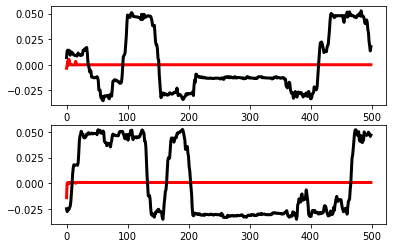

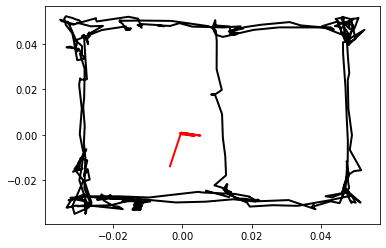

In [16]:
for x in batched_dataset.take(1):
    print(x.shape)
    qz_mean_est = vae.latent(x)
    print(qz_mean_est.shape)

qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
print(qz_est_norm[0].shape)

z_true_c = traj - traj.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)
print(z_true_norm.shape)
R = funs.compute_optimal_rotation(np.stack(qz_est_norm[0]), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
#qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
#qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[0,:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[0,:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure()
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[0,:,0], qz_est_norm_R[0,:,1], lw=2, color = 'r')